In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-di/Skin Disease Classification Dataset/New folder/Nail_psoriasis/Nail_psoriasis/Resize-450_400psoriatic-nail-001__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg
/kaggle/input/skin-di/Skin Disease Classification Dataset/New folder/Nail_psoriasis/Nail_psoriasis/superpixels-2003252__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg
/kaggle/input/skin-di/Skin Disease Classification Dataset/New folder/Nail_psoriasis/Nail_psoriasis/Crop-100450_0300psoriatic-nail-037__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg
/kaggle/input/skin-di/Skin Disease Classification Dataset/New folder/Nail_psoriasis/Nail_psoriasis/padd-00_10003260__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg
/kaggle/input/skin-di/Skin Disease Classification Dataset/New folder/Nail_psoriasis/Nail_psoriasis/superpixels-503248__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDBd.jpeg
/kaggle/input/skin-di/Skin Disease Classification Dataset/New folder/Nail_psoriasis/Na

In [12]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [16]:
data_dir = "/kaggle/input/skin-di/Skin Disease Classification Dataset/New folder"
valid_exts = ('.jpg', '.jpeg', '.png')

images = []
labels = []

for class_name in os.listdir(data_dir):
    outer_path = os.path.join(data_dir, class_name)
    nested_folder = os.path.join(outer_path, class_name)
    if not os.path.isdir(nested_folder):
        print(f"⛔ No nested folder found: {nested_folder}")
        continue

    for img_name in os.listdir(nested_folder):
        img_path = os.path.join(nested_folder, img_name)

        if os.path.isdir(img_path) or not img_name.lower().endswith(valid_exts):
            continue

        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(class_name)

In [17]:
def preprocess(img):
    try:
        # 1. Resize
        img = cv2.resize(img, (512, 512))

        # 2. Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 3. Black-Hat Transformation
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

        # 4. Create mask
        _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

        # 5. Inpaint to remove hair
        img = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)

        # 6. Gaussian Blur for denoising
        img = cv2.GaussianBlur(img, (7, 7), 0)

        return img
    except Exception as e:
        print("Preprocessing error:", e)
        return None

In [18]:
processed_images = []
valid_labels = []

for img, label in tqdm(zip(images, labels), desc="Preprocessing", total=len(images)):
    if img is not None:
        result = preprocess(img)
        if result is not None:
            processed_images.append(result)
            valid_labels.append(label)


Preprocessing: 100%|██████████| 9548/9548 [04:56<00:00, 32.15it/s]


In [19]:
from skimage.feature import graycomatrix, graycoprops

def extract_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)

    features = {
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'entropy': -np.sum(glcm * np.log2(glcm + 1e-10))
    }

    # RGB stats
    for i, color in enumerate(['r', 'g', 'b']):
        channel = img[:, :, i]
        features[f'{color}_mean'] = np.mean(channel)
        features[f'{color}_var'] = np.var(channel)
        features[f'{color}_std'] = np.std(channel)
        features[f'{color}_rms'] = np.sqrt(np.mean(np.square(channel)))

    return features


In [20]:
X = [extract_features(img) for img in tqdm(processed_images, desc="Extracting features")]
y = valid_labels


Extracting features: 100%|██████████| 9548/9548 [07:24<00:00, 21.50it/s]


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Convert features to DataFrame
X_df = pd.DataFrame(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_encoded, test_size=0.2, random_state=42)

# Classifiers to compare
models = {
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "KNN (k=10)": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree": DecisionTreeClassifier()
}

# Train and evaluate each
for name, clf in models.items():
    print(f"\n🔍 {name}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))



🔍 SVM (RBF)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

   Nail_psoriasis       0.42      0.49      0.45       518
          SJS-TEN       0.36      0.74      0.49       617
         Vitiligo       0.49      0.06      0.10       398
             acne       0.00      0.00      0.00       224
hyperpigmentation       0.00      0.00      0.00       153

         accuracy                           0.38      1910
        macro avg       0.25      0.26      0.21      1910
     weighted avg       0.33      0.38      0.30      1910


🔍 KNN (k=10)
                   precision    recall  f1-score   support

   Nail_psoriasis       0.52      0.62      0.57       518
          SJS-TEN       0.53      0.63      0.58       617
         Vitiligo       0.51      0.43      0.47       398
             acne       0.51      0.38      0.44       224
hyperpigmentation       0.44      0.18      0.26       153

         accuracy                           0.52      1910
        macro avg       0.50      0.4

In [22]:
from collections import Counter
from sklearn.utils import resample

df = X_df.copy()
df['label'] = y_encoded

# Balance by upsampling
max_size = df['label'].value_counts().max()
lst = [df]

for class_index, group in df.groupby('label'):
    if len(group) < max_size:
        lst.append(group.sample(max_size - len(group), replace=True))

df_balanced = pd.concat(lst)
X_balanced = df_balanced.drop('label', axis=1)
y_balanced = df_balanced['label'].values


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [24]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Define all classifiers
models = {
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "KNN (k=10)": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Train and evaluate each model
for name, clf in models.items():
    print(f"\n🔍 Evaluating: {name}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))



🔍 Evaluating: SVM (RBF)
                   precision    recall  f1-score   support

   Nail_psoriasis       0.34      0.43      0.38       630
          SJS-TEN       0.37      0.23      0.29       630
         Vitiligo       0.47      0.08      0.13       655
             acne       0.28      0.21      0.24       629
hyperpigmentation       0.29      0.66      0.40       620

         accuracy                           0.32      3164
        macro avg       0.35      0.32      0.29      3164
     weighted avg       0.35      0.32      0.29      3164


🔍 Evaluating: KNN (k=10)
                   precision    recall  f1-score   support

   Nail_psoriasis       0.57      0.60      0.59       630
          SJS-TEN       0.55      0.43      0.48       630
         Vitiligo       0.60      0.52      0.56       655
             acne       0.62      0.65      0.63       629
hyperpigmentation       0.64      0.80      0.72       620

         accuracy                           0.60      3164



🔍 Evaluating: SVM (RBF)
                   precision    recall  f1-score   support

   Nail_psoriasis       0.34      0.43      0.38       630
          SJS-TEN       0.37      0.23      0.29       630
         Vitiligo       0.47      0.08      0.13       655
             acne       0.28      0.21      0.24       629
hyperpigmentation       0.29      0.66      0.40       620

         accuracy                           0.32      3164
        macro avg       0.35      0.32      0.29      3164
     weighted avg       0.35      0.32      0.29      3164



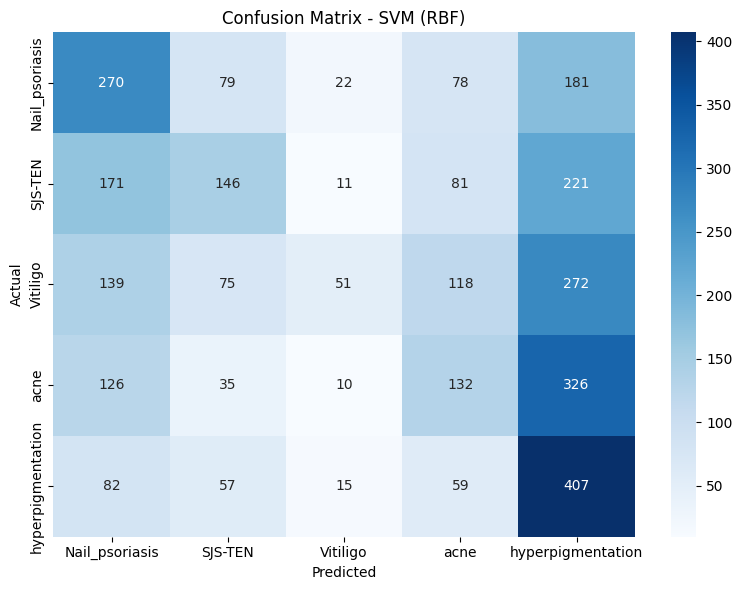


🔍 Evaluating: KNN (k=10)
                   precision    recall  f1-score   support

   Nail_psoriasis       0.57      0.60      0.59       630
          SJS-TEN       0.55      0.43      0.48       630
         Vitiligo       0.60      0.52      0.56       655
             acne       0.62      0.65      0.63       629
hyperpigmentation       0.64      0.80      0.72       620

         accuracy                           0.60      3164
        macro avg       0.59      0.60      0.59      3164
     weighted avg       0.59      0.60      0.59      3164



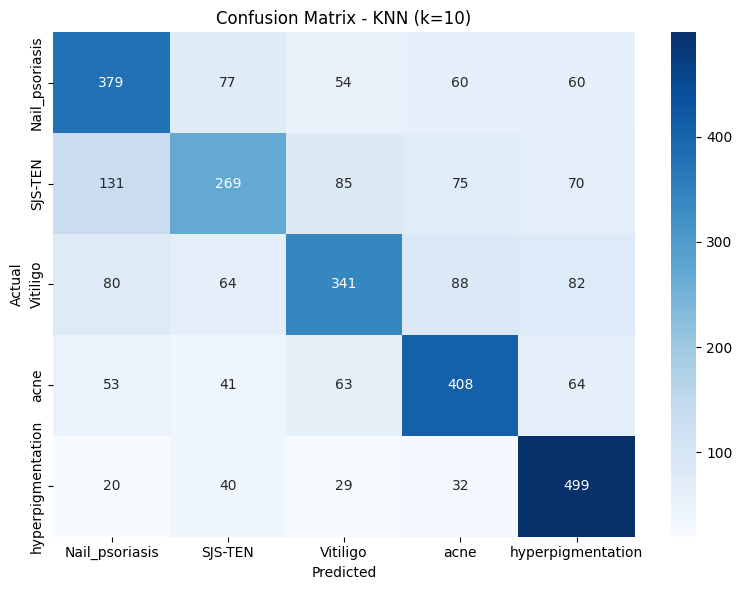


🔍 Evaluating: Decision Tree
                   precision    recall  f1-score   support

   Nail_psoriasis       0.81      0.78      0.80       630
          SJS-TEN       0.78      0.69      0.73       630
         Vitiligo       0.81      0.80      0.80       655
             acne       0.87      0.95      0.91       629
hyperpigmentation       0.92      0.99      0.96       620

         accuracy                           0.84      3164
        macro avg       0.84      0.84      0.84      3164
     weighted avg       0.84      0.84      0.84      3164



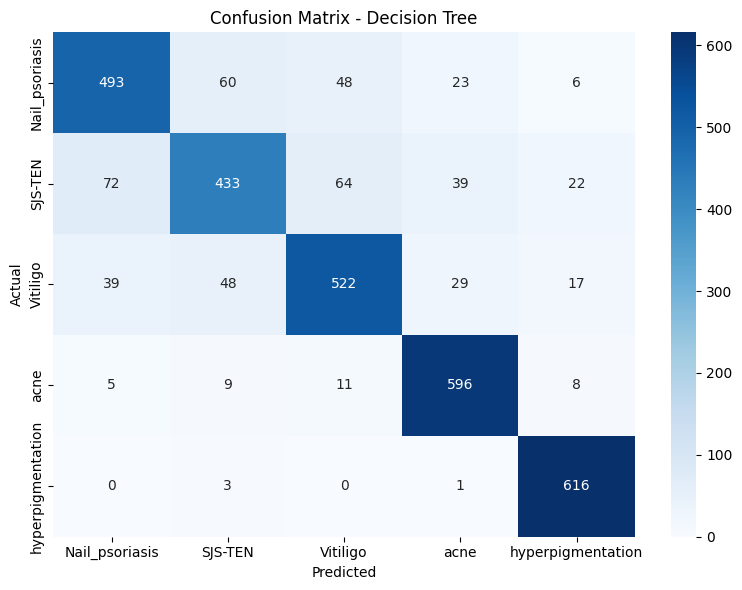

In [28]:
for name, model in models.items():
    print(f"\n🔍 Evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()